In [1]:
import xarray as xr

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import stats

import math

# font size for plots
SMALL_SIZE = 8
BIGGER_SIZE = 12
plt.rc('font', size=  BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rcParams["font.family"] = "serif"


#=================================================================================





ymin =   0.
ymax =  80.
#speed
var = 'speed'
ylabel = "Translation Speed"


ymin = -80.
ymax =  80.
var = 'tang'
ylabel = "Tangential Acceleration"

ymin =   0.
ymax =  80.
var = 'curv'
ylabel = "Curvature Acceleration"

#=================================================================================




#=================================================================================

#=================================================================================





# for all 
mon = '_ALL_'
monTitle = '[All Months]'
dom = '0_90'
titleString1 = '(a) Entire Atlantic ' + monTitle 
titleString2 = '(b) Entire Atlantic ' + monTitle 


# for JASO
mon = '_JASO_'
monTitle = '[July-October]'
dom = '20_50'
titleString1 = '(c) Atlantic: 20-50N ' + monTitle
titleString2 = '(d) Atlantic: 20-50N ' + monTitle

#for AS
mon = '_AS_'
monTitle = '[August-September]'
dom = '20_50'
titleString1 = '(e) Atlantic: 20-50N ' + monTitle
titleString2 = '(f) Atlantic: 20-50N ' + monTitle

#=================================================================================
fileName = "res/" + var+mon + dom+".nc"
output1 = "scatter_" + var+ mon +dom+".png"
output2 = "beta_" + var+ mon +dom+".png"
xlabelString = "Quantiles of Conditional " + ylabel
npfileName = "np_" + var+ mon +dom+".txt"

print(fileName)

res/curv_AS_20_50.nc


In [2]:
#open the data set
ds = xr.open_dataset(fileName)
print(ds)

<xarray.Dataset>
Dimensions:    (ncl0: 1, ncl1: 1, ncl2: 1, ncl3: 1, ncl5: 14748, ncl6: 14748, ncl7: 54, ncl8: 54, storm: 14748)
Dimensions without coordinates: ncl0, ncl1, ncl2, ncl3, ncl5, ncl6, ncl7, ncl8, storm
Data variables:
    startYear  (ncl0) int32 ...
    endYear    (ncl1) int32 ...
    latS       (ncl2) float32 ...
    latN       (ncl3) float32 ...
    Dates      (storm) datetime64[ns] ...
    Data       (ncl5) float64 ...
    Fracyear   (ncl6) float32 ...
    years      (ncl7) float32 ...
    yearly     (ncl8) float64 ...


In [3]:
print(ds.latS)
print(ds.latN)

<xarray.DataArray 'latS' (ncl2: 1)>
array([20.], dtype=float32)
Dimensions without coordinates: ncl2
<xarray.DataArray 'latN' (ncl3: 1)>
array([50.], dtype=float32)
Dimensions without coordinates: ncl3


Trend using annual mean values [one average value per year]
===============================

In [4]:
# now lets read the yearly averaged data and establish some basic trend using OLS = this is the trend of the mean
#
yData  = ds.yearly
years  = ds.years
dfA = pd.DataFrame({'years':years, 'yData':yData, 'const':1})
reg1 = sm.OLS(endog=dfA['yData'], exog=dfA[['const', 'years']],missing='drop')
results = reg1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  yData   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     4.631
Date:                Sat, 26 Dec 2020   Prob (F-statistic):             0.0361
Time:                        14:40:21   Log-Likelihood:                -140.92
No. Observations:                  54   AIC:                             285.8
Df Residuals:                      52   BIC:                             289.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        143.4775     58.314      2.460      0.0

const    143.477473
years     -0.062982
dtype: float64
percent change =  <xarray.DataArray 'years' ()>
array(-16.98362445)


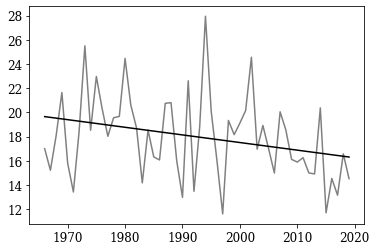

In [5]:
print (results.params)
intercept = results.params['const']
slope     =  results.params['years']
predic = intercept + slope*years

plt.plot(years, yData, color='grey',markersize=1)
plt.plot(years, predic, color='black',markersize=1)
pChange = 100.*(predic[-1]-predic[0])/abs(predic[0])
print ("percent change = ", pChange)

Now We use each track point along with its date (in fractional year)
====================================================================


Linear regression using numpy
================

R-squared : 0.002006
slope    : -0.056333
p value  : 0.000000
intercept  : 130.129189
percent change =  <xarray.DataArray 'years' ()>
array(-16.98362445)


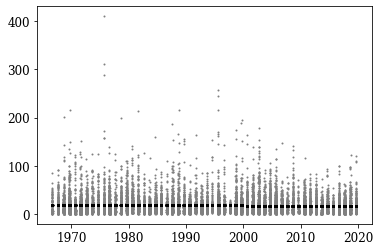

In [6]:
# Linear regression using numpy with fractional year


Data  = ds.Data
Time  = ds.Fracyear
slope, intercept, r_value, p_value, std_err = stats.linregress(Time.values,Data.values)
print("R-squared : %f" % r_value**2)
print ("slope    : %f" % slope)
print ("p value  : %f" % p_value)
print ("intercept  : %f" % intercept)
pChange = 100.*(predic[-1]-predic[0])/predic[0]
print ("percent change = ", pChange)

predic = intercept + slope*Time.values
plt.plot(Time, Data,'o', color='grey',markersize=1)
plt.plot(Time,predic,'o', color='black',markersize=1)


In [7]:
# the time is in fractional year. What if we just assign all values to an integer year index?
#
xdat = [math.floor(float(i)) for i in Time.values]
slope, intercept, r_value, p_value, std_err = stats.linregress(xdat,Data.values)
print("R-squared : %f" % r_value**2)
print ("slope    : %f" % slope)
print ("p value  : %f" % p_value)
print ("intercept  : %f" % intercept)
#notes: the difference between the previous cell and this is small



R-squared : 0.002006
slope    : -0.056340
p value  : 0.000000
intercept  : 130.103216


Convert to Pandas DF
====================

In [8]:
#
# use the time and data to create a pandas dataframe

df = pd.DataFrame({'Time':Time, 'Data':Data})

#standardize the acceleration values
#df.iloc[:,1:2] = df.iloc[:,1:2].apply(lambda x: (x-x.mean())/ x.std()
#stddev = df.iloc[:,1].std()
#print(stddev)
#df.iloc[:,1] = (df.iloc[:,1]-df.iloc[:,1].mean())/df.iloc[:,1].std()
# we could convert fractional year to just year by using the xdat that was created using the floor function
# i.e. all points in a year (e.g. 2001) will be assigned the time = 2001.
#df = pd.DataFrame({'Time':xdat, 'Data':Data})

# Notes: I tested the outcome of keeping the fractional year versus the integer year (floor). The differences were minute
# so, either should be fine

#print(df.iloc[:,1].mean())
#print(df.iloc[:,1].std())



A frst order polynomial fit to get the linear regression of the mean
=========================

In [9]:
# A frst order polynomial fit to get the linear regression
poly = smf.ols(formula='Data ~ 1 +  Time', data=df).fit()
print (poly.summary())

#print(dir(poly))
intercept = poly.params['Intercept']
slope =  poly.params['Time']
predic = intercept + slope*Time
pChange = 100.*(predic[-1]-predic[0])/abs(predic[0])
print ("percent change = ", pChange)



                            OLS Regression Results                            
Dep. Variable:                   Data   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     29.64
Date:                Sat, 26 Dec 2020   Prob (F-statistic):           5.29e-08
Time:                        14:40:22   Log-Likelihood:                -65006.
No. Observations:               14748   AIC:                         1.300e+05
Df Residuals:                   14746   BIC:                         1.300e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    130.1292     20.635      6.306      0.0

Now we proceed to Quantile Regression
======================================

In [10]:
mod = smf.quantreg('Data ~ Time', df)
result = mod.fit(q=.50)
print(result.summary())
#print (dir(res))

print(result.pvalues['Time'])
print(result.params['Time'])

                         QuantReg Regression Results                          
Dep. Variable:                   Data   Pseudo R-squared:            2.945e-05
Model:                       QuantReg   Bandwidth:                       2.582
Method:                 Least Squares   Sparsity:                        32.01
Date:                Sat, 26 Dec 2020   No. Observations:                14748
Time:                        14:40:22   Df Residuals:                    14746
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.0945     16.625      1.630      0.103      -5.492      59.681
Time          -0.0075      0.008     -0.897      0.370      -0.024       0.009

The condition number is large, 2.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.


In [11]:
#quantiles = np.arange(.05,.96, .05)

quantiles = [0.05,.10,.15,.2,.3,.5,.7,.8,.85,.90,.95]


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'],res.params['Time'], res.pvalues['Time']] + \
            res.conf_int().loc['Time'].tolist()
   
        
models = [fit_model(x1) for x1 in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'p', 'lb', 'ub'])

x = np.arange(1966,2021,1)
get_y = lambda a, b: a + b * x

n = len(quantiles)
print(n)

pc = [0.]*n
for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    perChange = 100.*(y[-1]-y[0])/abs(y[0])
    pc[i] = math.floor(perChange)
    print( models.q[i], y[-1], y[0],pc[i])
    
# add the percent change as a new column    
models['pc'] = pc   
    
print(models.round(4))

print(pc)



#np.savetxt(npfileName, models[["q","b","pc","p","lb","ub"]], fmt='%1.2f & %1.2f & %3.0f & %1.2f &  [ %1.2f, %1.2f ] \\')
np.savetxt(npfileName, models[["q","b","pc","p","lb","ub"]], fmt='%1.2f & %1.2f & %3.0f & %1.2f &  [ %1.2f, %1.2f ] \\')


11
0.05 1.5598910291220989 1.227194640131657 27
0.1 2.6395949551958537 2.270261449074571 16
0.15 3.5455212763895148 3.292347129260019 7
0.2 4.592207121697356 4.287529170597736 7
0.3 6.920692736953271 6.430821883594703 7
0.5 11.992586217712415 12.396301725533249 -4
0.7 19.092329459394364 21.279030637837252 -11
0.8 24.416769634942284 28.721281977998387 -15
0.85 28.005251410711253 34.60807378139032 -20
0.9 33.900700255359425 43.356885929433474 -22
0.95 44.575050399261954 62.140402203270355 -29
       q         a       b       p      lb      ub  pc
0   0.05  -10.8854  0.0062  0.0447  0.0001  0.0122  27
1   0.10  -11.1762  0.0068  0.0497  0.0000  0.0137  16
2   0.15   -5.9251  0.0047  0.2459 -0.0032  0.0126   7
3   0.20   -6.8050  0.0056  0.2201 -0.0034  0.0147   7
4   0.30  -11.4041  0.0091  0.1060 -0.0019  0.0201   7
5   0.50   27.0945 -0.0075  0.3698 -0.0238  0.0089  -4
6   0.70  100.8912 -0.0405  0.0007 -0.0638 -0.0172 -11
7   0.80  185.4374 -0.0797  0.0000 -0.1102 -0.0492 -15
8   0.85 

In [18]:
quantiles = np.arange(.05,.96, .05)

#quantiles = [0.05,.10,.15,.2,.5,.7,.8,.85,.90,.95]


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'],res.params['Time'], res.pvalues['Time']] + \
            res.conf_int().loc['Time'].tolist()
   
        
models = [fit_model(x1) for x1 in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'p', 'lb', 'ub'])

In [13]:
# Least square estimate of the trend of the mean

ols = smf.ols(formula='Data ~ Time', data=df).fit()
ols_ci = ols.conf_int().loc['Time'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['Time'],
           lb = ols_ci[0],
           ub = ols_ci[1],
           p=ols.pvalues['Time'])
print(ols)


{'a': 130.12919385228048, 'b': -0.056333426763216815, 'lb': -0.07661636041500393, 'ub': -0.0360504931114297, 'p': 5.2926377425311645e-08}


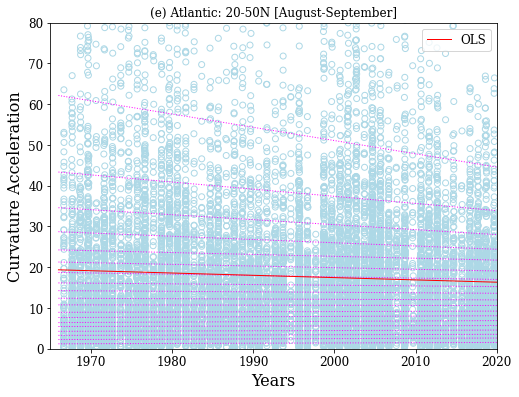

In [14]:
#x = np.arange(df.years.min(), df.years.max(), 50)

x = np.arange(1966,2021,1)
get_y = lambda a, b: a + b * x

n = 9
colors = pl.cm.jet(np.linspace(0,1,n))

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', linewidth=1, color='magenta')    
    
y = get_y(ols['a'], ols['b'])

ecolor = "lightblue"
ax.scatter(df.Time, df.Data, facecolors='none', edgecolors=ecolor) #, s=2 ,alpha=.7)
ax.plot(x, y, color='red', linewidth=1, label='OLS')
ax.set_xlim((1965,2020))
ax.set_ylim((ymin,ymax))
legend = ax.legend()
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel(ylabel, fontsize=16);
plt.title(titleString1)

plt.savefig(output1)


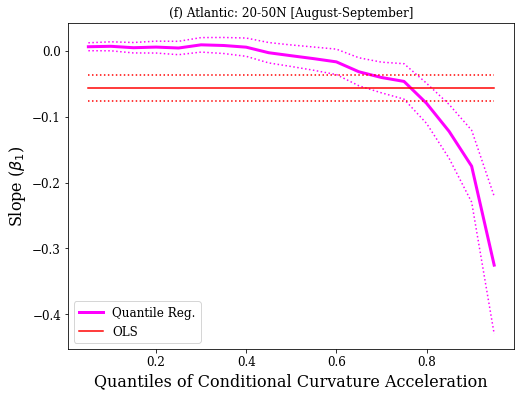

In [15]:
n = models.shape[0]
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(models.q, models.b,     color='magenta', linewidth=3, label='Quantile Reg.')
ax.plot(models.q, models.ub, linestyle='dotted', color='magenta')
ax.plot(models.q, models.lb, linestyle='dotted', color='magenta')

ax.plot(models.q, [ols['b']] * n, color='red', label='OLS')
ax.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
ax.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
legend = ax.legend()
ax.set_xlabel(xlabelString, fontsize=16)
ax.set_ylabel('Slope (' + r'$\beta_1$' +')', fontsize=16);
plt.title(titleString2)

plt.savefig(output2)
